In [1]:
import os
import shutil

def organize_braTS_data(src_root="./data", dst_root="./dataset"):
    """
    Extract ./TumorSegmentationData to data and label form
    """
    os.makedirs(os.path.join(dst_root, "data"), exist_ok=True)
    os.makedirs(os.path.join(dst_root, "label"), exist_ok=True)
    
    for folder in sorted(os.listdir(src_root)):
        folder_path = os.path.join(src_root, folder)
        if os.path.isdir(folder_path):
            case_number = folder.split("_")[-1]  # Extracting case number
            
            for file in os.listdir(folder_path):
                src_file = os.path.join(folder_path, file)
                if file.endswith("_t1.nii"):
                    dst_file = os.path.join(dst_root, "data", f"data_{case_number}_t1.nii")
                    shutil.move(src_file, dst_file)
                elif file.endswith("_seg.nii"):
                    dst_file = os.path.join(dst_root, "label", f"label_{case_number}.nii")
                    shutil.move(src_file, dst_file)

if __name__ == "__main__":
    organize_braTS_data()

In [4]:
import os
import nibabel as nib
import numpy as np
from scipy import ndimage
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

In [27]:
DEVICE = None
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Using CUDA!")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU!")
EPOCHS = 100
TRAIN_SPLIT = 0.8
LR = 2e-3
STEP_SIZE = 3
GAMMA = 0.1
MANUAL_SEED = 42
BATCH_SIZE = 16
TARGET_SIZE = 32

Using CUDA!


In [28]:
import torch
import numpy as np
import random

def set_random_seed(seed):
    """
    모든 관련 라이브러리의 랜덤 시드를 고정합니다.
    
    Args:
        seed (int): 고정할 랜덤 시드 값
    """
    # Python 내장 랜덤 시드 고정
    random.seed(seed)
    
    # NumPy 랜덤 시드 고정
    np.random.seed(seed)
    
    # PyTorch 랜덤 시드 고정
    torch.manual_seed(seed)  # CPU에서 PyTorch 랜덤 시드 고정
    torch.cuda.manual_seed(seed)  # GPU에서 PyTorch 랜덤 시드 고정 (CUDA 장치)
    torch.cuda.manual_seed_all(seed)  # 모든 GPU에서 PyTorch 랜덤 시드 고정
    
    # CuDNN 관련 설정
    torch.backends.cudnn.deterministic = True  # 결정적 알고리즘을 사용하여 결과 고정
    torch.backends.cudnn.benchmark = False  # 벤치마크 모드를 비활성화하여 성능 최적화 방지

# 시드 고정 예시
set_random_seed(MANUAL_SEED)

In [29]:
def read_nifti_file(filepath):
    """Read and load volume"""
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    """Normalize the volume"""
    min_val = -1000
    max_val = 400
    volume[volume < min_val] = min_val
    volume[volume > max_val] = max_val
    volume = (volume - min_val) / (max_val - min_val)
    volume = volume.astype("float32")
    return volume


def resize(image, target_size):
    """이미지 크기 조정 (PIL 없이 numpy 기반)"""
    if image.ndim == 2:
        # 흑백 이미지 (H, W) 크기 조정
        return scipy.ndimage.zoom(image, (target_size[0] / image.shape[0], target_size[1] / image.shape[1]), order=1)
    elif image.ndim == 3:
        # 컬러 이미지 (H, W, C) 크기 조정
        zoom_factors = (target_size[0] / image.shape[0], target_size[1] / image.shape[1])
        resized = np.stack([scipy.ndimage.zoom(image[..., i], zoom_factors, order=1) for i in range(image.shape[2])], axis=-1)
        return resized
    else:
        raise ValueError("Unsupported image dimensions")

            
def resize_volume(img):
    """Resize to 64x64x64"""
    desired_depth = TARGET_SIZE
    desired_width = TARGET_SIZE
    desired_height = TARGET_SIZE
    
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    
    depth_factor = desired_depth / current_depth
    width_factor = desired_width / current_width
    height_factor = desired_height / current_height
    
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [30]:
import os

# 경로 설정 (현재 작업 디렉토리 기준)
data_dir = './dataset/label'

# 숫자 001부터 369까지 파일이 있는지 확인 (_001, _002, ...)
expected_files = [f"label_{str(i)}.nii" for i in range(1, 25)]
print(expected_files)
# 실제 파일 목록 가져오기
try:
    actual_files = sorted(os.listdir(data_dir))
    # 실제 파일 목록에 있는지 확인
    missing_files = [file for file in expected_files if file not in actual_files]

    if missing_files:
        print("Missing files:", missing_files)
    else:
        print("All expected files are present.")
except FileNotFoundError:
    print(f"The directory {data_dir} does not exist.")


['label_1.nii', 'label_2.nii', 'label_3.nii', 'label_4.nii', 'label_5.nii', 'label_6.nii', 'label_7.nii', 'label_8.nii', 'label_9.nii', 'label_10.nii', 'label_11.nii', 'label_12.nii', 'label_13.nii', 'label_14.nii', 'label_15.nii', 'label_16.nii', 'label_17.nii', 'label_18.nii', 'label_19.nii', 'label_20.nii', 'label_21.nii', 'label_22.nii', 'label_23.nii', 'label_24.nii']
Missing files: ['label_1.nii', 'label_2.nii', 'label_3.nii', 'label_4.nii', 'label_5.nii', 'label_6.nii', 'label_7.nii', 'label_8.nii', 'label_9.nii', 'label_10.nii', 'label_11.nii', 'label_12.nii', 'label_13.nii', 'label_14.nii', 'label_15.nii', 'label_16.nii', 'label_17.nii', 'label_18.nii', 'label_19.nii', 'label_20.nii', 'label_21.nii', 'label_22.nii', 'label_23.nii', 'label_24.nii']


In [31]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

class BraTSDataset(Dataset):
    def __init__(self, data_dir, label_dir):
        self.data_paths = sorted([f for f in os.listdir(data_dir) if f.endswith('.nii')])
        self.label_paths = sorted([f for f in os.listdir(label_dir) if f.endswith('.nii')])
        self.data_dir = data_dir
        self.label_dir = label_dir

        # 데이터와 라벨의 개수가 일치하는지 확인
        assert len(self.data_paths) == len(self.label_paths), \
            f"Mismatch between data and label files: {len(self.data_paths)} | {len(self.label_paths)}"
    
    def __len__(self):
        return len(self.data_paths)
    
    def __getitem__(self, idx):
        data_path = os.path.join(self.data_dir, self.data_paths[idx])
        label_path = os.path.join(self.label_dir, self.label_paths[idx])
        
        data = read_nifti_file(data_path)
        label = read_nifti_file(label_path)     

        # 최소, 최대 값 계산
        # min_val = np.min(data)
        # max_val = np.max(data)
        # print(min_val, max_val)
        data = normalize(data)
        data = resize_volume(data)
        label = resize_volume(label)

        # Convert numpy to torch tensor
        data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)     # Add channel dimension
        label = torch.tensor(label, dtype=torch.long)                   # For segmentation tasks, long type is needed for one-hot encoding
    
        # One-hot encoding: (64, 64, 64) -> (64, 64, 64, 5) -> (5, 64, 64, 64)
        # label_one_hot = F.one_hot(label, num_classes=5).permute(3, 0, 1, 2).float()
        label_one_hot = label
        return data, label_one_hot


In [32]:
dataset = BraTSDataset("./dataset/data", "./dataset/label")
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

data shape:  torch.Size([1, 32, 32, 32]) <class 'torch.Tensor'>
label shape:  torch.Size([32, 32, 32]) <class 'torch.Tensor'>
(32, 32, 32)
torch.Size([32, 32, 32])


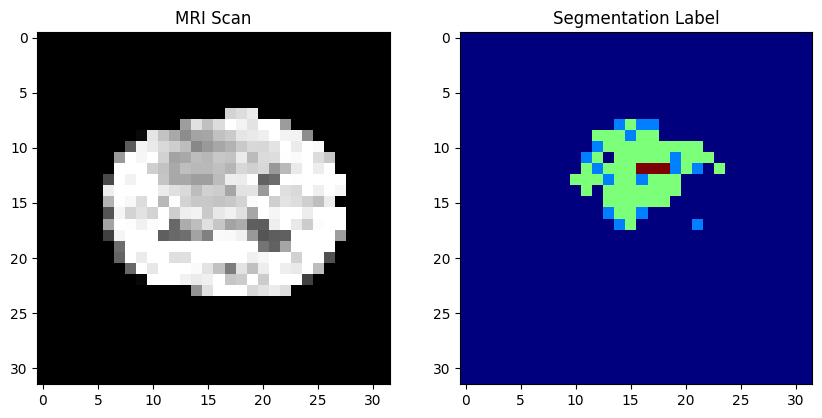

In [33]:
def visualize_sample(dataset, idx=0):
    """Visualize a single sample from the dataset"""
    data, label = dataset[idx]
    print("data shape: ", data.shape, type(data))
    print("label shape: ", label.shape, type(label))
    
    data = data.squeeze().numpy()
    # label = torch.argmax(label, dim=0)
    
    print(data.shape)
    print(label.shape)
    slice_idx = data.shape[-1] // 2  # Select middle slice
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(data[:, :, slice_idx], cmap='gray')
    axes[0].set_title("MRI Scan")
    
    axes[1].imshow(label[:, :, slice_idx], cmap='jet')
    axes[1].set_title("Segmentation Label")
    
    plt.show()

visualize_sample(dataset, idx=0)

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """ (Conv3D -> BN -> ReLU) * 2 """
    def __init__(self, in_channels, mid_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UpConv(nn.Module):
    """ (Conv3D -> ReLU) * 2 """
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.upconv = nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.upconv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels, base_channels=32):
        super(UNet3D, self).__init__()

        self.encoder1 = DoubleConv(in_channels, base_channels, base_channels * 2)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.encoder2 = DoubleConv(base_channels * 2, base_channels * 2, base_channels * 4)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.encoder3 = DoubleConv(base_channels * 4, base_channels * 4, base_channels * 8)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.encoder4 = DoubleConv(base_channels * 8, base_channels * 8, base_channels * 16)

        self.upconv3 = UpConv(base_channels * 16, base_channels * 16)
        self.decoder3 = DoubleConv(base_channels * 24, base_channels * 8, base_channels * 8)

        self.upconv2 = UpConv(base_channels * 8, base_channels * 8)
        self.decoder2 = DoubleConv(base_channels * 12, base_channels * 4, base_channels * 4)

        self.upconv1 = UpConv(base_channels * 4, base_channels * 4)
        self.decoder1 = DoubleConv(base_channels * 6, base_channels * 2, base_channels * 2)

        self.outconv = nn.Conv3d(base_channels * 2, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        dec3 = self.upconv3(enc4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        out = self.outconv(dec1)

        return out

In [35]:
model = UNet3D(in_channels=1, out_channels=5) # Tumor 1,2,3,4 | 배경
x = torch.randn(1, 1, 64, 64, 64)  # Example 3D volume
output = model(x)
print(output.shape)

torch.Size([1, 5, 64, 64, 64])


In [36]:
import torch
torch.cuda.empty_cache()

In [37]:
from collections import Counter
import numpy as np

# 데이터셋에서 클래스별 샘플 개수 계산
labels = []  # 전체 데이터셋에서 라벨을 수집해야 함

for _, label in train_loader:
    # label = torch.argmax(label, dim=1)  # 원-핫 벡터를 클래스 인덱스로 변환
    labels.extend(label.cpu().numpy().flatten())  # numpy 배열로 변환 후 리스트에 추가

# 클래스별 샘플 개수 계산
class_counts = Counter(labels)
total_samples = sum(class_counts.values())

# 가중치 계산: 총 샘플 수 / (클래스별 샘플 수 * 클래스 개수)
class_weights = {cls: total_samples / (count * len(class_counts)) for cls, count in class_counts.items()}
class_weights = torch.tensor(list(class_weights.values()), dtype=torch.float).to(DEVICE)

print("Class Weights:", class_weights)

Class Weights: tensor([2.0202e-01, 5.1284e+01, 4.6823e+01, 2.7771e+02, 1.7859e+02],
       device='cuda:0')


In [38]:
import os

#현재 폴더 경로; 작업 폴더 기준
print(os.getcwd())

/home/jjpark/SKKAI/3D-Tumor-Segmentation


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.utils.data import random_split, DataLoader

# Create directories if they don't exist
os.makedirs('./model', exist_ok=True)
os.makedirs('./results', exist_ok=True)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, verbose=True):
        """
        Early stopping to stop training when validation loss doesn't improve.
        
        Args:
            patience (int): Number of epochs to wait after last improvement
            min_delta (float): Minimum change to qualify as an improvement
            verbose (bool): If True, prints a message when early stopping triggers
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        
    def __call__(self, val_loss):
        """
        Check if training should be stopped.
        
        Args:
            val_loss (float): Current validation loss
            
        Returns:
            bool: True if training should stop, False otherwise
        """
        if val_loss < self.best_loss - self.min_delta:
            # Validation loss has improved
            self.best_loss = val_loss
            self.counter = 0
        else:
            # Validation loss has not improved
            self.counter += 1
            if self.verbose:
                print(f'Early stopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print('Early stopping triggered')
        
        return self.early_stop

# Dataset splitting
dataset_size = len(train_dataset)
val_size = int(dataset_size * 0.2)  
train_size = dataset_size - val_size

train_subset, val_subset = random_split(
    train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42) 
)

train_loader = DataLoader(
    train_subset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS if 'NUM_WORKERS' in globals() else 4
)

val_loader = DataLoader(
    val_subset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS if 'NUM_WORKERS' in globals() else 4
)

model.to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

# Initialize tracking variables
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, min_delta=0.001, verbose=True)

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.numel()
    return correct / total

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0
    train_acc = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for data, label in progress_bar:
        data, label = data.to(DEVICE), label.to(DEVICE)

        optimizer.zero_grad()

        output = model(data)
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        acc = calculate_accuracy(output, label)
        
        train_loss += loss.item()
        train_acc += acc

        progress_bar.set_postfix(loss=loss.item(), acc=f"{acc:.4f}")
    
    train_loss = train_loss / len(train_loader)
    train_acc = train_acc / len(train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_acc = 0
    
    with torch.no_grad():
        val_progress_bar = tqdm(val_loader, desc=f"Validation {epoch+1}/{EPOCHS}")
        for data, label in val_progress_bar:
            data, label = data.to(DEVICE), label.to(DEVICE)
            
            output = model(data)
            loss = criterion(output, label)
            
            acc = calculate_accuracy(output, label)
            
            val_loss += loss.item()
            val_acc += acc
            
            val_progress_bar.set_postfix(loss=loss.item(), acc=f"{acc:.4f}")
    
    val_loss = val_loss / len(val_loader)
    val_acc = val_acc / len(val_loader)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save model if it's the best so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './model/3DUNet_best.pth')
        print(f"✓ Saved new best model with validation loss: {best_val_loss:.4f}")
    
    # Early stopping check
    if early_stopping(val_loss):
        print(f"Early stopping triggered after {epoch+1} epochs")
        break
        
    # Learning rate scheduler step
    scheduler.step()

print(f"\nTraining completed! Best validation loss: {best_val_loss:.4f}")

# Plot training and validation metrics for actual epochs trained
epochs_trained = len(train_losses)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_trained+1), train_losses, 'b-', label='Training')
plt.plot(range(1, epochs_trained+1), val_losses, 'r-', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_trained+1), train_accs, 'b-', label='Training')
plt.plot(range(1, epochs_trained+1), val_accs, 'r-', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('./results/training_curves.png')
plt.show()

print("Loading best model for visualization...")
model.load_state_dict(torch.load('./model/3DUNet_best.pth'))
model.eval()

sample_data, sample_label = next(iter(val_loader))
sample_data, sample_label = sample_data.to(DEVICE), sample_label.to(DEVICE)

with torch.no_grad():
    sample_output = model(sample_data)
    _, predicted = torch.max(sample_output, 1)

def visualize_3d_predictions(sample_idx=0, num_slices=3):
    """
    Visualize predictions on a 3D volume
    """
    input_vol = sample_data[sample_idx, 0].cpu().numpy()  
    label_vol = sample_label[sample_idx].cpu().numpy()
    pred_vol = predicted[sample_idx].cpu().numpy()
    
    d, h, w = input_vol.shape
    
    z_indices = np.linspace(d//4, 3*d//4, num_slices, dtype=int)
    
    fig, axes = plt.subplots(num_slices, 3, figsize=(15, 5*num_slices))
    
    if num_slices == 1:
        axes = axes.reshape(1, -1)
    
    for i, z in enumerate(z_indices):
        axes[i, 0].imshow(input_vol[z], cmap='gray')
        axes[i, 0].set_title(f'Input (Slice {z})')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(label_vol[z], cmap='viridis')
        axes[i, 1].set_title(f'Ground Truth (Slice {z})')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_vol[z], cmap='viridis')
        axes[i, 2].set_title(f'Prediction (Slice {z})')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('./results/3d_prediction_results.png', dpi=300)
    plt.show()

visualize_3d_predictions(sample_idx=0, num_slices=3)

Epoch 1/100:   0%|          | 0/15 [00:05<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB. GPU 0 has a total capacity of 11.65 GiB of which 10.12 MiB is free. Including non-PyTorch memory, this process has 11.49 GiB memory in use. Of the allocated memory 11.32 GiB is allocated by PyTorch, and 60.41 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

: 

In [33]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import sys
import nibabel as nib

def save_as_nifti(tensor, filename):
    """
    Save a tensor as a NIfTI file.
    tensor: Tensor to be saved as NIfTI.
    filename: The output file name.
    """
    # Convert tensor to numpy array (NIfTI requires numpy arrays)
    nifti_img = nib.Nifti1Image(tensor, affine=np.eye(4))  # Using identity matrix as affine
    
    # Save as NIfTI file
    nib.save(nifti_img, filename)

def multiclass_dice_coeff(input, target, epsilon=1e-6):
    """
    Compute the Dice Score for multi-class segmentation.
    
    Args:
        input (torch.Tensor): Model output logits (C, H, W, D).
        target (torch.Tensor): Ground truth labels (C, H, W, D).
        epsilon (float): Small value to avoid division by zero.
        
    Returns:
        mean_dice (float): Mean Dice Score across all classes.
    """
    input = torch.argmax(input, dim=0)  # (H, W, D) - get class index with highest logit
    
    # Ensure target is long type
    target = target.int()
    
    # Calculate intersection and union
    intersection = (input * target).sum()
    union = input.sum() + target.sum()

    # Compute Dice score
    dice = (2. * intersection + epsilon) / (union + epsilon)

    return dice

# Test loop
save = False
total_dice = 0
total_samples = 0

model.to(DEVICE)
model.eval()
total_loss = 0
criterion = nn.CrossEntropyLoss(weight=class_weights)

with torch.no_grad():
    for batch_idx, (data, label) in tqdm(enumerate(test_loader), desc="Testing"):
        data, label = data.to(DEVICE), label.to(DEVICE)
        
        data_clone = data.clone()
        label_clone = label.clone()

        # Check data dimensions before operations
        print(f"Original data shape: {data.shape}")
        print(f"Original label shape: {label.shape}")
        
        # Model forward pass
        output = model(data)  # Output shape should be (batch, C, D, H, W)
        print(f"Model output shape: {output.shape}")
        
        # Convert label for loss calculation - FIXED DIMENSION ISSUE
        # Based on the error, we need to ensure label_clone has the shape (batch, D, H, W)
        if label_clone.dim() == 5:  # If one-hot encoded with shape (batch, C, D, H, W)
            label_clone = torch.argmax(label_clone, dim=1)  # Convert to class indices (batch, D, H, W)
        elif label_clone.dim() == 4 and label_clone.shape != output.shape[2:]:
            # Handle possible dimension mismatch
            # For 3D UNet, ensure target has 3 spatial dimensions
            print("Warning: Possible dimension mismatch in label tensor")
            
        print(f"Processed label shape: {label_clone.shape}")
        
        # Ensure label has correct type for CrossEntropyLoss
        label_clone = label_clone.long()
        
        # Compute loss - this line was causing the error
        try:
            loss = criterion(output, label_clone)
            total_loss += loss.item()
        except RuntimeError as e:
            print(f"Error in loss calculation: {e}")
            print(f"Output shape: {output.shape}, Label shape: {label_clone.shape}")
            # Continue with visualization even if loss fails
            loss = torch.tensor(0.0, device=DEVICE)

        # Process each sample in the batch
        for i in range(data.size(0)):
            # Dice score calculation
            try:
                dice = multiclass_dice_coeff(output[i], label[i])
                print(f"Sample {i} Dice score: {dice.item():.4f}")
                total_dice += dice.item()
                total_samples += 1
            except Exception as e:
                print(f"Error calculating Dice score: {e}")
                continue

            # File names for saving
            original_filename = f"original_{batch_idx}_{i}.nii"
            pred_filename = f"pred_{batch_idx}_{i}.nii"
            label_filename = f"label_{batch_idx}_{i}.nii"

            # Process tensors for visualization
            pred = torch.argmax(output[i], dim=0)  # (D, H, W) - class index with highest logit
            original = data_clone[i, 0] if data_clone.shape[1] == 1 else torch.argmax(data_clone[i], dim=0)
            gt_label = torch.argmax(label[i], dim=0) if label.shape[1] > 1 else label[i]

            # Print stats for the first sample
            if save == False:
                print("\nPrediction statistics:")
                unique_elements, counts = torch.unique(pred, return_counts=True)
                print(f"Classes: {unique_elements}")
                print(f"Counts: {counts}")
                print(f"Total voxels: {counts.sum()}")
                
                print("\nGround truth statistics:")
                unique_elements, counts = torch.unique(gt_label, return_counts=True)
                print(f"Classes: {unique_elements}")
                print(f"Counts: {counts}")
                print(f"Total voxels: {counts.sum()}")
                
                print(f"\nTensor shapes:")
                print(f"Original: {original.shape}")
                print(f"Prediction: {pred.shape}")
                print(f"Ground truth: {gt_label.shape}")

                # Save as NIfTI 
                save_as_nifti(original.cpu().numpy().astype(np.int16), original_filename)
                save_as_nifti(pred.cpu().numpy().astype(np.int16), pred_filename)
                save_as_nifti(gt_label.cpu().numpy().astype(np.int16), label_filename)

                save = True
                print(f"Saved visualization files: {original_filename}, {pred_filename}, {label_filename}")
        
# Compute average metrics
if total_samples > 0:
    avg_dice = total_dice / total_samples
    avg_loss = total_loss / len(test_loader)

    print(f"\nTest Results:")
    print(f"Test Dice Accuracy: {avg_dice:.4f}")
    print(f"Average Test Loss: {avg_loss:.4f}")
else:
    print("No valid samples were processed")

Testing: 0it [00:00, ?it/s]

Original data shape: torch.Size([16, 1, 32, 32, 32])
Original label shape: torch.Size([16, 32, 32, 32])
Model output shape: torch.Size([16, 5, 32, 32, 32])
Processed label shape: torch.Size([16, 32, 32, 32])


Testing: 1it [00:01,  1.45s/it]

Sample 0 Dice score: 0.3471

Prediction statistics:
Classes: tensor([0, 1, 2, 3, 4], device='cuda:0')
Counts: tensor([27676,  2534,  1748,   168,   642], device='cuda:0')
Total voxels: 32768

Ground truth statistics:
Classes: tensor([ 0, 17, 18, 19, 20, 21, 22], device='cuda:0')
Counts: tensor([915,  18,  43,  28,   8,  10,   2], device='cuda:0')
Total voxels: 1024

Tensor shapes:
Original: torch.Size([32, 32, 32])
Prediction: torch.Size([32, 32, 32])
Ground truth: torch.Size([32, 32])
Saved visualization files: original_0_0.nii, pred_0_0.nii, label_0_0.nii
Sample 1 Dice score: 0.2385
Sample 2 Dice score: 0.1067
Sample 3 Dice score: 0.1484
Sample 4 Dice score: 0.2491
Sample 5 Dice score: 0.2451
Sample 6 Dice score: 0.2169
Sample 7 Dice score: 0.1846
Sample 8 Dice score: 0.1620
Sample 9 Dice score: 0.1920
Sample 10 Dice score: 0.3016
Sample 11 Dice score: 0.4062
Sample 12 Dice score: 0.2519
Sample 13 Dice score: 0.1395
Sample 14 Dice score: 0.1943
Sample 15 Dice score: 0.2204
Original d

Testing: 2it [00:02,  1.41s/it]

Sample 0 Dice score: 0.3619
Sample 1 Dice score: 0.1901
Sample 2 Dice score: 0.0939
Sample 3 Dice score: 0.3685
Sample 4 Dice score: 0.0567
Sample 5 Dice score: 0.2732
Sample 6 Dice score: 0.1444
Sample 7 Dice score: 0.4331
Sample 8 Dice score: 0.0162
Sample 9 Dice score: 0.1260
Sample 10 Dice score: 0.2749
Sample 11 Dice score: 0.2156
Sample 12 Dice score: 0.2682
Sample 13 Dice score: 0.1659
Sample 14 Dice score: 0.2975
Sample 15 Dice score: 0.2899
Original data shape: torch.Size([16, 1, 32, 32, 32])
Original label shape: torch.Size([16, 32, 32, 32])
Model output shape: torch.Size([16, 5, 32, 32, 32])
Processed label shape: torch.Size([16, 32, 32, 32])


Testing: 3it [00:04,  1.41s/it]

Sample 0 Dice score: 0.2823
Sample 1 Dice score: 0.2684
Sample 2 Dice score: 0.1349
Sample 3 Dice score: 0.2605
Sample 4 Dice score: 0.1028
Sample 5 Dice score: 0.3676
Sample 6 Dice score: 0.5626
Sample 7 Dice score: 0.1340
Sample 8 Dice score: 0.1432
Sample 9 Dice score: 0.3568
Sample 10 Dice score: 0.4031
Sample 11 Dice score: 0.3838
Sample 12 Dice score: 0.1049
Sample 13 Dice score: 0.2837
Sample 14 Dice score: 0.4046
Sample 15 Dice score: 0.2911
Original data shape: torch.Size([16, 1, 32, 32, 32])
Original label shape: torch.Size([16, 32, 32, 32])
Model output shape: torch.Size([16, 5, 32, 32, 32])
Processed label shape: torch.Size([16, 32, 32, 32])


Testing: 4it [00:05,  1.39s/it]

Sample 0 Dice score: 0.0941
Sample 1 Dice score: 0.1835
Sample 2 Dice score: 0.3144
Sample 3 Dice score: 0.0620
Sample 4 Dice score: 0.1273
Sample 5 Dice score: 0.2450
Sample 6 Dice score: 0.1914
Sample 7 Dice score: 0.0386
Sample 8 Dice score: 0.1376
Sample 9 Dice score: 0.0919
Sample 10 Dice score: 0.2300
Sample 11 Dice score: 0.1653
Sample 12 Dice score: 0.1363
Sample 13 Dice score: 0.2128
Sample 14 Dice score: 0.2311
Sample 15 Dice score: 0.1669


Testing: 5it [00:06,  1.29s/it]

Original data shape: torch.Size([10, 1, 32, 32, 32])
Original label shape: torch.Size([10, 32, 32, 32])
Model output shape: torch.Size([10, 5, 32, 32, 32])
Processed label shape: torch.Size([10, 32, 32, 32])
Sample 0 Dice score: 0.0519
Sample 1 Dice score: 0.3020
Sample 2 Dice score: 0.0451
Sample 3 Dice score: 0.1432
Sample 4 Dice score: 0.1297
Sample 5 Dice score: 0.1881
Sample 6 Dice score: 0.1846
Sample 7 Dice score: 0.1809
Sample 8 Dice score: 0.2642
Sample 9 Dice score: 0.2621

Test Results:
Test Dice Accuracy: 0.2168
Average Test Loss: 1.2601


In [34]:
import torch

# 직접 0과 1을 선언한 5x5x5 입력 텐서
input_tensor = torch.tensor([
    [[0, 1, 0, 1, 0], [1, 0, 1, 0, 1], [0, 1, 0, 1, 0], [1, 0, 1, 0, 1], [0, 1, 0, 1, 0]],
    [[1, 1, 0, 0, 1], [0, 1, 1, 0, 0], [1, 0, 1, 1, 1], [0, 0, 1, 0, 1], [1, 1, 0, 1, 0]],
    [[0, 0, 1, 1, 0], [1, 0, 0, 1, 1], [0, 1, 1, 0, 0], [1, 1, 0, 1, 0], [0, 0, 1, 1, 1]],
    [[1, 0, 1, 0, 1], [0, 1, 0, 1, 0], [1, 1, 0, 1, 1], [0, 1, 1, 0, 0], [1, 0, 0, 1, 1]],
    [[0, 1, 1, 0, 0], [1, 0, 1, 1, 0], [0, 0, 1, 0, 1], [1, 1, 0, 1, 0], [0, 1, 1, 0, 1]]
], dtype=torch.float32)

# 직접 0과 1을 선언한 5x5x5 타겟 텐서
target_tensor = torch.tensor([
    [[0, 1, 0, 1, 0], [1, 0, 1, 0, 1], [0, 1, 0, 1, 0], [1, 0, 1, 0, 1], [0, 1, 0, 1, 0]],
    [[1, 1, 0, 0, 1], [0, 1, 1, 0, 0], [1, 0, 1, 1, 1], [0, 0, 1, 0, 1], [1, 1, 0, 1, 0]],
    [[0, 0, 1, 1, 0], [1, 0, 0, 1, 1], [0, 1, 1, 0, 0], [1, 1, 0, 1, 0], [0, 0, 1, 1, 1]],
    [[1, 0, 1, 0, 1], [0, 1, 0, 1, 0], [1, 1, 0, 1, 1], [0, 1, 1, 0, 0], [1, 0, 0, 1, 1]],
    [[0, 1, 1, 0, 0], [1, 0, 1, 1, 0], [0, 0, 1, 0, 1], [1, 1, 0, 1, 0], [0, 1, 1, 0, 1]]
], dtype=torch.float32)

# Dice coefficient 함수 정의
def multiclass_dice_coeff(input, target, epsilon=1e-6):
    intersection = (input * target).sum()
    union = input.sum() + target.sum()
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice

# Dice Score 계산
dice_score = multiclass_dice_coeff(input_tensor, target_tensor)

# 결과 출력
print("Dice Score:", dice_score.item())


Dice Score: 1.0
